# **Variational Quantum Eigensolver**
---
<img src="http://www.doc.ic.ac.uk/~afd/images/logo_imperial_college_london.png" align = "left" width=200>
 <br><br><br><br>
 
- Copyright (c) Antoine Jacquier, 2023. All rights reserved

- Author: Jack Jacquier <a.jacquier@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.9

In [1]:
import numpy as np
from random import random
from scipy.optimize import minimize

from qiskit import *
from numpy import linalg as LA

## Generating a Hamiltonian from Pauli operators

In [2]:
def matprint(mat, fmt="g"):
    ## Just to print a matrix nicely
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [3]:
GATE_NAMES = ["I", "Z", "X", "Y"]

In [4]:
coefficients = 3.*np.random.rand(len(GATE_NAMES))

In [5]:
hamiltonian = {}
for (i,g) in enumerate(GATE_NAMES):
    hamiltonian[g] = coefficients[i]

In [6]:
print("Pauli decomposition of the matrix: ")
for gate_name in hamiltonian:
    print(gate_name, ": ", hamiltonian[gate_name])

Pauli decomposition of the matrix: 
I :  1.3721317026796056
Z :  0.45387378089030195
X :  1.8607947059115135
Y :  2.9925492675576097


### Matrix representation

In [7]:
pauli_matrices = {"I": np.array([[1., 0.],[0., 1.]]),
                  "Z": np.array([[1., 0.],[0., -1.]]),
                  "X": np.array([[0., 1.],[1., 0.]]),
                  "Y": np.array([[0., -1j],[1j, 0.]])
                 }

H_matrix = np.zeros((2,2))

for g in GATE_NAMES:
    H_matrix = H_matrix + hamiltonian[g]*pauli_matrices[g]

print("The 2*2 matrix representation of the Hamiltonian is")
matprint(H_matrix)

The 2*2 matrix representation of the Hamiltonian is
      1.82601+0j  1.86079-2.99255j  
1.86079+2.99255j       0.918258+0j  


In [8]:
eigenpairs = LA.eig(H_matrix)
for i in range(len(eigenpairs)):
    print("Eigenpair: ", np.round(eigenpairs[0][i], 4), np.round(eigenpairs[1][i], 4))

Eigenpair:  (4.9251+0j) [ 0.7509+0.j     -0.3487+0.5608j]
Eigenpair:  (-2.1809-0j) [0.3487+0.5608j 0.7509+0.j    ]


In [9]:
classical_min_eigenvalue = np.min(eigenpairs[0].real)
print("Minimum eigenvalue: ", classical_min_eigenvalue)

Minimum eigenvalue:  -2.1808824353850826


# TEST VQE

Recall that any vector in $\mathbb{C}^2$, viewed as a one-qubit quantum state, can be written as
$$
|\psi\rangle = \begin{pmatrix}
\cos\left(\frac{\theta}{2}\right)\\
\mathrm{e}^{\mathrm{i}\varphi}\sin\left(\frac{\theta}{2}\right)\\
\end{pmatrix},
$$
for some $\varphi, \theta \in \mathbb{R}$.
Now, with the rotation matrices
$$
R_{X}(\theta) := 
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\mathrm{i}\sin\left(\frac{\theta}{2}\right)\\
-\mathrm{i}\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}
\qquad\text{and}\qquad
R_{Y}(\theta) := 
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right)\\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix},
$$
we know that we can find $\theta_0, \theta_1$ such that
$$
|\psi\rangle = R_{Y}(\theta_1)R_{X}(\theta_0)|0\rangle.
$$

Note that the general `qiskit` U gate is defined as
$$
U(\theta, \phi, \lambda) := 
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\mathrm{e}^{\mathrm{i}\lambda}\sin\left(\frac{\theta}{2}\right)\\
\mathrm{e}^{\mathrm{i}\phi}\sin\left(\frac{\theta}{2}\right) & \mathrm{e}^{\mathrm{i}(\phi+\lambda)}\cos\left(\frac{\theta}{2}\right)
\end{pmatrix}.
$$
In particular, 
$$
U\left(\frac{\pi}{2}, 0, \pi\right) = \mathrm{H} = \frac{1}{\sqrt{2}}\begin{pmatrix}1&1\\1&-1\end{pmatrix}
\qquad\text{and}\qquad
U\left(\frac{\pi}{2}, 0, \frac{\pi}{2}\right) = \mathrm{G} = \frac{1}{\sqrt{2}}\begin{pmatrix}1&-\mathrm{i}\\1&\mathrm{i}\end{pmatrix}.
$$

In [10]:
def param_qc(thetas, gate_name):
    """
    Ansatz circuit for the optimization
    :params: parameters for the rotation gates
    :measure: Pauli measurement reference
    :returns a quantum circuit.
    """

    qc = QuantumCircuit(1)

    ## create a general one-qubit quantum state (using the two rotations matrices above)
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)

    ## Add an extra gate
    if gate_name == 'X':
        qc.h(0)
        
    elif gate_name == 'Y':
        qc.u(.5*np.pi, 0, .5*np.pi, 0) ## Corresponds to the G gate

    qc.measure_all()
    return qc

In [11]:
def quantum_expectation(thetas, gate_name, nbShots):
    # measure
    if gate_name == 'I':
        return 1
    else:
        qc = param_qc(thetas, gate_name)
    
    shots = nbShots
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expectation = 0
    for c in counts:
        sign = +1
        
        if c == '1':
            sign = -1
        expectation += sign * counts[c] / shots
        
    return expectation

In [12]:
def vqe(thetas, args):
    args = hamiltonian, GATE_NAMES, nbShots
    total_expectation = 0.
    
    for gatename in GATE_NAMES:
        weight_gate = 0.
        for k in hamiltonian.keys():
            if k == gatename:
                weight_gate = hamiltonian[k]
        total_expectation += weight_gate * quantum_expectation(thetas, gatename, nbShots)

    return total_expectation

In [13]:
### Define a starting point for the vector of parameters [theta[0], theta[1]]
thetas = np.random.rand(2)*np.pi
##np.array([.3*np.pi, .3*np.pi])
print("Starting parameter points: ", thetas)
nbShots = 5000

vqe_result = minimize(vqe, thetas, args=[hamiltonian, GATE_NAMES, nbShots], method="Nelder-Mead", tol=1e-20)

Starting parameter points:  [2.96444595 1.74123558]


In [14]:
print('Optimal parameters theta:', vqe_result.x)
print('VQE ground state energy  %.4f' %vqe_result.fun)
print('Classical ground state energy  %.4f' %classical_min_eigenvalue)

Optimal parameters theta: [2.09674299 1.89970459]
VQE ground state energy  -2.1204
Classical ground state energy  -2.1809


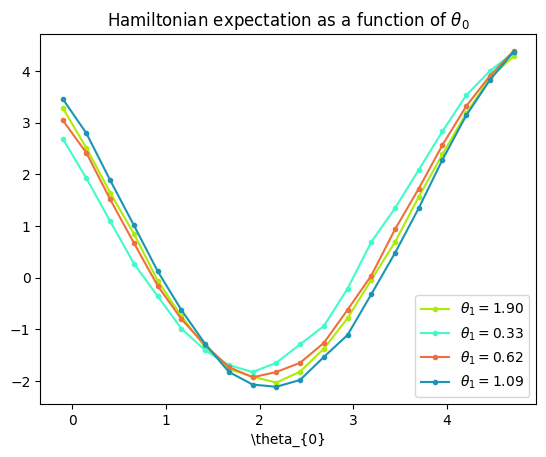

In [15]:
import matplotlib.pylab as plt
nbShots = 5000
M = 20
tt = np.linspace(-0.1, 1.5*np.pi, M)
N = 4
theta1 = np.random.rand(N)*np.pi
theta1[0] = vqe_result.x[1]
currentVal = np.zeros((N, M))
mycolors = np.random.rand(N,3)
arguments = hamiltonian, GATE_NAMES, nbShots

for k in range(M):
    for i in range(N):
        currentVal[i,k] = vqe(np.array([tt[k], theta1[i]]), arguments)

for i in range(N):
    plt.plot(tt, currentVal[i,:], c=mycolors[i], marker='.', label=r'$\theta_1=$%.2f' %theta1[i])

plt.title(r'Hamiltonian expectation as a function of r$\theta_0$')
plt.xlabel(r'\theta_{0}')
plt.legend(loc="best")
plt.show()

### Checking the output

$$
R_{X}(\theta) := 
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\mathrm{i}\sin\left(\frac{\theta}{2}\right)\\
-\mathrm{i}\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}
\qquad\text{and}\qquad
R_{Y}(\theta) := 
\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right)\\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix},
$$

$$
U\left(\frac{\pi}{2}, 0, \pi\right) = \mathrm{H} = \frac{1}{\sqrt{2}}\begin{pmatrix}1&1\\1&-1\end{pmatrix}
\qquad\text{and}\qquad
U\left(\frac{\pi}{2}, 0, \frac{\pi}{2}\right) = \mathrm{G} = \frac{1}{\sqrt{2}}\begin{pmatrix}1&-\mathrm{i}\\1&\mathrm{i}\end{pmatrix}.
$$

#### Vector of parameters $(\theta_0, \theta_1)$:

In [16]:
print("Optimal vector of parameters: ", vqe_result.x)

Optimal vector of parameters:  [2.09674299 1.89970459]


#### Original Hamiltonian decomposition:

In [17]:
hamiltonian

{'I': 1.3721317026796056,
 'Z': 0.45387378089030195,
 'X': 1.8607947059115135,
 'Y': 2.9925492675576097}

In [18]:
def check_eigenstate(vqe_result, hamiltonian, pauli_matrices):
    theta = vqe_result.x
    Rx = np.matrix([[np.cos(theta[0]/2.), -1j*np.sin(theta[0]/2.)], [-1j*np.sin(theta[0]/2.), np.cos(theta[0]/2.)]])
    Ry = np.matrix([[np.cos(theta[1]/2.), -np.sin(theta[1]/2.)], [np.sin(theta[1]/2.), np.cos(theta[1]/2.)]])
    
    H = np.matrix([[1, 1], [1, -1]]) / np.sqrt(2.)
    G = np.matrix([[1, -1j], [1, 1j]]) / np.sqrt(2.)
    
    initialstate = np.matrix([[1], [0]])
    
    hamiltonian_matrix = np.zeros((2,2))

    for g in GATE_NAMES:
        hamiltonian_matrix = hamiltonian_matrix + hamiltonian[g]*pauli_matrices[g]

    psi_param = np.matmul(Ry, np.matmul(Rx, initialstate))

    return vqe_result.fun*psi_param, hamiltonian_matrix*psi_param

In [19]:
check_eigenstate(vqe_result, hamiltonian, pauli_matrices)

(matrix([[-0.61556263-1.49451933j],
         [-0.86052341+1.0690822j ]]),
 matrix([[-0.22354795-0.86565366j],
         [-1.19640064+1.71734773j]]))